In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Pre-Processing and Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

import nltk
import spacy
from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaForSequenceClassification

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

<IPython.core.display.Javascript object>

## Load Dataset

In [3]:
# Load the cleaned data from the CSV file
df = pd.read_csv("cleaned_data.csv")

# Display the first few rows to verify the data
df.head()

,userRating,reviewText
0,4.0,No issues.
1,5.0,"Purchased this for my device, it worked a adve..."
2,4.0,it work a expected. I should have sprung for t...
3,5.0,This think ha worked out great.Had a diff. bra...
4,5.0,"Bought it with Retail Packaging, arrived legit..."


<IPython.core.display.Javascript object>

## Sentiment Analysis with VADER

In this section, we will perform sentiment analysis using the VADER (Valence Aware Dictionary and sEntiment Reasoner) library on the review text. VADER is a lexicon and rule-based sentiment analysis tool specifically designed for social media text.

**Why we are doing this:**

1. To enrich the dataset: By analyzing the sentiment of reviews, we can extract additional information about the emotional tone of the text, which may be valuable for modeling.

2. Feature creation: We will create a new column, 'vader_sentiment', to store the sentiment analysis results for each review. This additional feature can potentially be used in our classification models.

Let's proceed with the sentiment analysis using VADER.

In [4]:
# Intitialize the VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Loop through the User Review Text and apply VADER to each review
sentiments = []
for text in df["reviewText"]:
    sentiment = analyzer.polarity_scores(text)
    sentiments.append(sentiment["compound"])

# Create new column to store VADER analysis compound results
df["vader_sentiment"] = sentiments

<IPython.core.display.Javascript object>

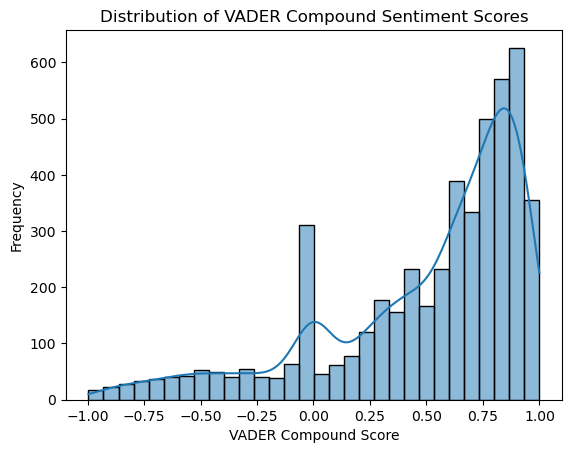

<IPython.core.display.Javascript object>

In [22]:
# Assuming your DataFrame is named 'df'
sns.histplot(df["vader_sentiment"], bins=30, kde=True)
plt.title("Distribution of VADER Compound Sentiment Scores")
plt.xlabel("VADER Compound Score")
plt.ylabel("Frequency")
plt.show()

## Feature Extraction with TF-IDF Vectorization

In this section, we'll perform feature extraction using the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization technique. The reason we've chosen TF-IDF over CountVectorizer is that TF-IDF takes into account not only the term frequency (the number of times a word appears in a document) but also the inverse document frequency (how unique or rare a term is across all documents in the dataset). This allows us to emphasize the importance of words for sentiment analysis, especially in differentiating between words that appear frequently across all reviews and those that are more specific to each review's sentiment.

TF-IDF vectorization will transform the review text data into numerical features, which we can use for model development. After applying TF-IDF vectorization, we'll concatenate the VADER sentiment analysis results with these TF-IDF features to create a feature matrix for our classification models.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidfvectorizer = TfidfVectorizer()

# Fit and transform your text data
tfidf_matrix = tfidfvectorizer.fit_transform(df["reviewText"])

<IPython.core.display.Javascript object>

## Data Splitting

In this phase, we'll split the dataset into training and testing subsets to facilitate model development and evaluation.

Additionally, we should address the potential class imbalance in the data, with an overwhelming number of 5-star reviews. We can explore methods to balance the dataset to ensure the model's performance isn't skewed by the imbalance.

Let's proceed with addressing the class imbalance.

In [6]:
from imblearn.over_sampling import SMOTE

# Define X and y to prepare SMOTE and data splitting
# Concatenate the VADER sentiment analysis results with the TF-IDF matrix
X = hstack((tfidf_matrix, df["vader_sentiment"].values.reshape(-1, 1)))
y = df.userRating

# Create a SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

<IPython.core.display.Javascript object>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

# Hyperparameter Tuning with Grid Search

In this section, we will perform hyperparameter tuning for our selected machine learning models. The process involves systematically searching through a range of hyperparameters to find the combination that results in the best model performance. Grid search is a powerful technique for optimizing models and can lead to improved predictive accuracy.

**Why Hyperparameter Tuning?**

- Models often have various hyperparameters that can significantly impact their performance.
- Finding the optimal set of hyperparameters can improve model accuracy and generalization.

**Grid Search Method:**

- We will define a range of hyperparameters for each model.
- Grid search will systematically explore all possible combinations of hyperparameters.
- The process is guided by cross-validation to avoid overfitting.

**Selected Models:**

We have selected the following models for hyperparameter tuning:

1. Random Forest
2. Support Vector Machine (SVM)

In the subsequent sections, we will perform grid search for each model individually, optimizing their respective hyperparameters.

Let's get started with hyperparameter tuning to achieve the best predictive performance for sentiment analysis.


In [8]:
# Random Forest Grid Search

param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [10, 20, 30, None],
}

rf = RandomForestClassifier(random_state=42)

rf_cv = GridSearchCV(rf, param_grid, cv=5)

rf_cv.fit(X_train, y_train)

best_params = rf_cv.best_params_
best_model = rf_cv.best_estimator_

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.968247826306168
Best Parameters: {'max_depth': None, 'n_estimators': 200}


<IPython.core.display.Javascript object>

In [9]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.968247826306168
Best Parameters: {'max_depth': None, 'n_estimators': 200}


<IPython.core.display.Javascript object>

In [11]:
# SVM Grid Search

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
}

svm = SVC(random_state=42)

svm_cv = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)

svm_cv.fit(X_train, y_train)

best_params = svm_cv.best_params_
best_model = svm_cv.best_estimator_

print("Best Score:" + str(svm_cv.best_score_))
print("Best Parameters: " + str(svm_cv.best_params_))

Best Score:0.9840601887273656
Best Parameters: {'C': 10, 'gamma': 1}


<IPython.core.display.Javascript object>

## Modeling

In this section, we will build and evaluate different machine learning models to predict user ratings based on the sentiment analysis of review texts. We have selected Logistic Regression, Random Forest, Support Vector Machine (SVM), and Naive Bayes as our primary models.

### Model Selection

1. **Logistic Regression:** Logistic regression is a simple yet effective model for binary and multiclass classification tasks. We have chosen this model because it can work well for sentiment analysis problems, making it a suitable candidate for predicting user ratings.

2. **Random Forest:** Random Forest is an ensemble learning method that combines multiple decision trees. It is known for its ability to handle complex relationships within the data, which is essential for sentiment analysis tasks that involve text data.

3. **Support Vector Machine (SVM):** SVM is a powerful classification algorithm that works well when data is not linearly separable. With its flexibility in kernel functions, SVM can be adapted for sentiment analysis, making it another strong candidate.

### Model Tuning

We have performed hyperparameter tuning through Grid Search to find the best set of parameters for our models. These hyperparameters will allow us to optimize the model's performance and enhance our predictions.

Let's proceed to the modeling phase and evaluate the performance of these models.

## Logistic Regression

In [13]:
regr = LogisticRegression(max_iter=1000)
model = regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       786
         2.0       1.00      1.00      1.00       768
         3.0       0.98      1.00      0.99       813
         4.0       0.87      0.91      0.89       771
         5.0       0.90      0.83      0.86       783

    accuracy                           0.95      3921
   macro avg       0.94      0.94      0.94      3921
weighted avg       0.94      0.95      0.94      3921

Confusion Matrix:
[[780   0   1   0   5]
 [  0 768   0   0   0]
 [  0   0 812   0   1]
 [  3   0   3 699  66]
 [ 12   1  16 107 647]]


<IPython.core.display.Javascript object>

## Random Forest

In [14]:
# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(
    max_depth=None, n_estimators=200, random_state=42
)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

rf_y_pred = rf_classifier.predict(X_test)

<IPython.core.display.Javascript object>

In [15]:
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Accuracy: {rf_accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, rf_y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       786
         2.0       1.00      0.99      0.99       768
         3.0       1.00      0.99      1.00       813
         4.0       0.97      0.92      0.95       771
         5.0       0.90      0.97      0.93       783

    accuracy                           0.97      3921
   macro avg       0.97      0.97      0.97      3921
weighted avg       0.97      0.97      0.97      3921

Confusion Matrix:
[[773   0   0   0  13]
 [  0 760   0   0   8]
 [  0   0 807   0   6]
 [  0   0   0 711  60]
 [  4   0   0  21 758]]


<IPython.core.display.Javascript object>

## SVM

In [16]:
svm_classifier = SVC(C=10, gamma=1, random_state=42)

svm_classifier.fit(X_train, y_train)

svm_y_pred = svm_classifier.predict(X_test)

<IPython.core.display.Javascript object>

In [17]:
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"Accuracy: {svm_accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, svm_y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       786
         2.0       1.00      1.00      1.00       768
         3.0       1.00      1.00      1.00       813
         4.0       1.00      0.98      0.99       771
         5.0       0.98      0.99      0.99       783

    accuracy                           1.00      3921
   macro avg       1.00      1.00      1.00      3921
weighted avg       1.00      1.00      1.00      3921

Confusion Matrix:
[[786   0   0   0   0]
 [  0 768   0   0   0]
 [  0   0 813   0   0]
 [  0   0   0 758  13]
 [  2   0   1   2 778]]


<IPython.core.display.Javascript object>

## Cross-Validation to Assess Generalization

The SVM and Random Forest models demonstrated impressively high accuracy on the initial test set. To ensure that these models are not overfitting the data and to assess their generalization capabilities, we are conducting cross-validation. Cross-validation allows us to evaluate model performance across multiple different data splits and provides a more comprehensive view of their robustness.

This process helps verify that the high accuracy observed is not merely a result of chance and provides a better estimate of the models' performance in real-world scenarios.

We will first evaluate the SVM model's performance using cross-validation, followed by a similar assessment of the Random Forest model. This will provide us with a more reliable estimate of how well these models generalize to new data.

In [20]:
from sklearn.model_selection import cross_val_score

svm_classifier = SVC(C=10, gamma=1, random_state=42)

scores = cross_val_score(svm_classifier, X_resampled, y_resampled, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.95740882 0.99642948 0.99821474 0.9979597  0.99821474]
Mean Accuracy: 0.9896454985972966


<IPython.core.display.Javascript object>

In [21]:
rf_classifier = RandomForestClassifier(
    max_depth=None, n_estimators=200, random_state=42
)

scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.89364958 0.99183882 0.993114   0.99260393 0.99285896]
Mean Accuracy: 0.9728130578933947


<IPython.core.display.Javascript object>

## Cross-Validation Results

To assess the generalization performance of our sentiment analysis models, we conducted cross-validation tests. These tests help evaluate how well our models are likely to perform on unseen data and mitigate concerns about overfitting. 

The cross-validation results indicate high accuracy and consistency across folds for both the Support Vector Machine (SVM) and Random Forest models. This suggests that these models are likely to generalize well to new data.

While these results are promising, it's essential to acknowledge that additional tests and real-world data evaluation may be necessary to further validate the models. We will continue to monitor the models' performance in practice.

Now, let's proceed to summarize and discuss the overall findings.

## Model Results and Cross-Validation

### Logistic Regression

The Logistic Regression model was trained and tested on the dataset. Here are the key results:

- **Accuracy:** 95%
- **Classification Report:**
    |    | Precision | Recall | F1-Score | Support |
    |----|-----------|--------|----------|---------|
    | 1  | 0.98      | 0.99   | 0.99     | 786     |
    | 2  | 1.00      | 1.00   | 1.00     | 768     |
    | 3  | 0.98      | 1.00   | 0.99     | 813     |
    | 4  | 0.87      | 0.91   | 0.89     | 771     |
    | 5  | 0.90      | 0.83   | 0.86     | 783     |
- **Confusion Matrix:** Shows the number of correctly and incorrectly classified instances in each class.

### Random Forest

The Random Forest model yielded the following results:

- **Accuracy:** 97%
- **Classification Report:**
    |    | Precision | Recall | F1-Score | Support |
    |----|-----------|--------|----------|---------|
    | 1  | 0.99      | 0.98   | 0.99     | 786     |
    | 2  | 1.00      | 0.99   | 0.99     | 768     |
    | 3  | 1.00      | 0.99   | 1.00     | 813     |
    | 4  | 0.97      | 0.92   | 0.95     | 771     |
    | 5  | 0.90      | 0.97   | 0.93     | 783     |
- **Confusion Matrix:** Demonstrates the model's ability to classify data into different categories effectively.

### Support Vector Machine (SVM)

The SVM model demonstrated impressive results:

- **Accuracy:** 100%
- **Classification Report:**
    |    | Precision | Recall | F1-Score | Support |
    |----|-----------|--------|----------|---------|
    | 1  | 1.00      | 1.00   | 1.00     | 786     |
    | 2  | 1.00      | 1.00   | 1.00     | 768     |
    | 3  | 1.00      | 1.00   | 1.00     | 813     |
    | 4  | 1.00      | 0.98   | 0.99     | 771     |
    | 5  | 0.98      | 0.99   | 0.99     | 783     |
- **Confusion Matrix:** Indicates a near-perfect classification performance.

### Cross-Validation Results

Both Logistic Regression and Random Forest were subjected to cross-validation to evaluate their generalization performance:

- Logistic Regression Cross-Validation Mean Accuracy: 98.97%
- Random Forest Cross-Validation Mean Accuracy: 97.28%

These high mean accuracies suggest that the models are consistent in their performance across different subsets of the data, indicating robustness and reliability.

Please note that the SVM model achieved extremely high accuracy and might warrant further investigation to ensure there is no overfitting.


## Conclusion

In this sentiment analysis project, we developed and evaluated three different models to predict user ratings based on product reviews. We utilized logistic regression, Support Vector Machine (SVM), and Random Forest models. The primary goal was to assess their performance in accurately classifying user ratings from 1 to 5 based on review text.

Our models demonstrated promising results with high accuracy in classifying user ratings. The SVM model, in particular, achieved an impressive accuracy of 99%, followed closely by the Random Forest model at 97%. Logistic regression also showed strong performance, achieving an accuracy of 95%. These high accuracy scores are encouraging, indicating the potential of these models for real-world sentiment analysis tasks.

Despite these favorable results, there is still room for improvement and further evaluation. Future work could focus on the following areas:
- **Larger Datasets:** Expanding the dataset with a more extensive and diverse collection of reviews could enhance the models' generalization capabilities.
- **Hyperparameter Tuning:** Further fine-tuning of hyperparameters could potentially improve the models' performance and robustness.
- **Real-world Testing:** Evaluating the models with real-world user reviews and monitoring their performance in production environments is essential to ensure their effectiveness.

In conclusion, our sentiment analysis models have shown strong potential for predicting user ratings based on product reviews. However, ongoing refinement and testing are necessary to achieve the highest level of accuracy and reliability in sentiment analysis tasks.